In [1]:
import subprocess
import time
subprocess.check_output(["maturin", "develop"])

🍹 Building a mixed python/rust project
🔗 Found pyo3 bindings
🐍 Found CPython 3.10 at /home/wint3rmute/code/luthier/.venv/bin/python
📡 Using build options features from pyproject.toml
    Finished dev [unoptimized + debuginfo] target(s) in 0.02s
📦 Built wheel for CPython 3.10 to /tmp/.tmpDkncC5/luthier-0.1.0-cp310-cp310-linux_x86_64.whl
🛠 Installed luthier-0.1.0


b''

In [2]:
import luthier.luthier
from luthier.luthier import DspGraph, SineOscillator
import matplotlib.pyplot as plt
from copy import deepcopy
from IPython.display import Audio, display, Image, HTML
from luthier import dsp
SAMPLE_RATE = 22050

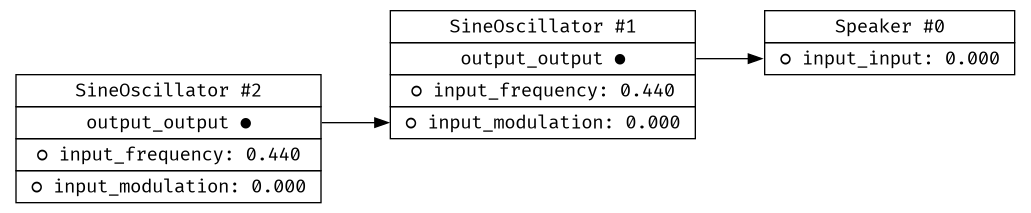

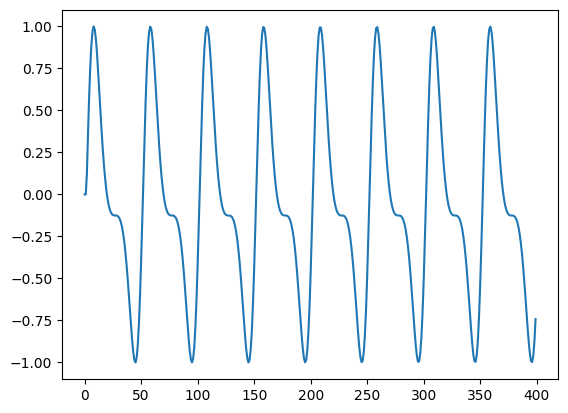

In [4]:
g = DspGraph()

sine = SineOscillator()
sine.input_frequency = 0.440
sine_id = g.add_sine(sine)

g.patch( sine_id, "output_output", 1, "input_modulation" )

display(Image(g.draw()))
plt.plot(g.play(400))